In [1]:
import os
import xarray as xr
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(style='ticks',font_scale=2)

In [2]:
def ols(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan, np.nan

    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if (len(x)<20 or len(y)<20):
        return np.nan, np.nan
    if (y==y.max()).all() or (x==x.max()).all():
        return np.nan,np.nan
    mod = smapi.OLS(y,smapi.add_constant(x)).fit()
    return mod.params[1], mod.pvalues[1]


In [3]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [6]:
ims = xr.open_dataset(os.path.join(data_dir,'ims_24km','wy_sc.nc')).sel(time=slice("1998","2022"))
era5 = xr.open_dataset(os.path.join(data_dir,'era5','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ims['sc'] = ims['sc'].clip(max=365)
era5['cold_days'] = 151-era5['warm_days'].clip(max=151)
era5['cold_frac'] = era5['cold_days']/151

sc_mask = (ims['sc'].median("time")>30)&(ims['sc'].median("time")<364) # keep placs with snow cover in >3/4 years
ims = ims.where(sc_mask)
era5 = era5.where(sc_mask)
era5['tavg_clim'] = era5['tavg'].mean("time")
era5['std_clim'] = era5['tavg_std'].mean("time")


gridded_dsc_dt, gridded_dsc_dt_p = xr.apply_ufunc(ols,
                                                era5['tavg'],
                                                ims['sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
gridded_dsc_dt = 100*gridded_dsc_dt/ims['sc'].mean("time")
gridded_dsc_dt.name = 'dsc_dt'
gridded_dsc_dt_p.name = 'dsc_dt_p'

gridded_df = xr.merge([era5[['tavg_clim','std_clim','cold_frac',]].mean("time"),
                      gridded_dsc_dt,gridded_dsc_dt_p,]).to_dataframe().dropna()


In [7]:
snotel = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc'))
ecad = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc'))
ghcnd = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc'))
insitu = xr.concat([snotel,ecad,ghcnd],dim='site').sel(time=slice("1998","2022"))
insitu = insitu.where(insitu['wy_sc'].median("time")>30,drop=True)
insitu = insitu.where((insitu['wy_sc'].count("time")>=20)&(insitu['tavg'].count("time")>=20),drop=True)
insitu['cold_frac']=1-insitu['warm_days_tavg']/151
insitu['wy_sc'] = insitu['wy_sc'].clip(max=365)

insitu_dsc_dt, insitu_dsc_dt_p = xr.apply_ufunc(ols,
                                                insitu['tavg'],
                                                insitu['wy_sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
insitu_dsc_dt = 100*insitu_dsc_dt/insitu['wy_sc'].mean("time")
insitu_dsc_dt.name = 'dsc_dt'
insitu_dsc_dt_p.name = 'dsc_dt_p'

insitu_df = xr.merge([insitu[['tavg','tavg_std','cold_frac',]].mean("time"),
                      insitu_dsc_dt,insitu_dsc_dt_p,]).to_dataframe()


In [8]:
# days below freezing expected based on Gaussian distribution
mus = np.arange(-40,11)
sigmas = np.arange(1,13)
cd = pd.DataFrame(index=sigmas,columns=mus)
for m in mus:
    for s in sigmas:
        cd.at[s,m] = NormalDist(m,s).cdf(0)

In [9]:
# bin grid points in 1-degree mean x variability bins
gridded_df['tavg_bin'] = pd.cut(gridded_df['tavg_clim'],np.arange(-40.5,10,1),labels=np.arange(-39.5,10,1)-0.5)
gridded_df['std_bin'] = pd.cut(gridded_df['std_clim'],np.arange(0.5,12,1),labels=np.arange(1.5,12.5,1)-0.5)
gridded_df['sig'] = (gridded_df['dsc_dt_p']<0.01).astype(int)

bin_avg = gridded_df.groupby(['tavg_bin','std_bin'])[['dsc_dt','cold_frac','sig']].mean()
bin_cnt = gridded_df.groupby(['tavg_bin','std_bin'])[['dsc_dt','cold_frac','sig']].count()
dsc_dt_avg = bin_avg.pivot_table(values='dsc_dt',index='std_bin',columns='tavg_bin')
dsc_dt_cnt = bin_cnt.pivot_table(values='dsc_dt',index='std_bin',columns='tavg_bin')
dsc_dt_avg = dsc_dt_avg[dsc_dt_cnt>10]
cold_frac_avg = bin_avg.pivot_table(values='cold_frac',index='std_bin',columns='tavg_bin')
cold_frac_avg = cold_frac_avg[dsc_dt_cnt>10]
sig_avg = bin_avg.pivot_table(values='sig',index='std_bin',columns='tavg_bin')
sig_avg = sig_avg[dsc_dt_cnt>10]
sig_avg_std = (sig_avg-np.min(sig_avg)) / (np.max(sig_avg)-np.min(sig_avg))
sig_avg_scale = sig_avg_std * (1-0.1) + 0.1

cold_frac_avg = cold_frac_avg.reindex(labels=np.arange(1,13),columns=np.arange(-40,11))
dsc_dt_avg = dsc_dt_avg.reindex(labels=np.arange(1,13),columns=np.arange(-40,11))
sig_avg = sig_avg.reindex(labels=np.arange(1,13),columns=np.arange(-40,11))
sig_avg_scale = sig_avg_scale.reindex(labels=np.arange(1,13),columns=np.arange(-40,11))

/scratch/f004260/ipykernel_2320281/1922615400.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = gridded_df.groupby(['tavg_bin','std_bin'])[['dsc_dt','cold_frac','sig']].mean()
/scratch/f004260/ipykernel_2320281/1922615400.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_cnt = gridded_df.groupby(['tavg_bin','std_bin'])[['dsc_dt','cold_frac','sig']].count()
/scratch/f004260/ipykernel_2320281/1922615400.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain 

/scratch/f004260/ipykernel_2320281/3894263564.py:8: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax2.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
/scratch/f004260/ipykernel_2320281/3894263564.py:19: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax4.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
/scratch/f004260/ipykernel_2320281/3894263564.py:40: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax5.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
/scratch/f004260/ipykernel_2320281/3894263564.py:62: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax6.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')


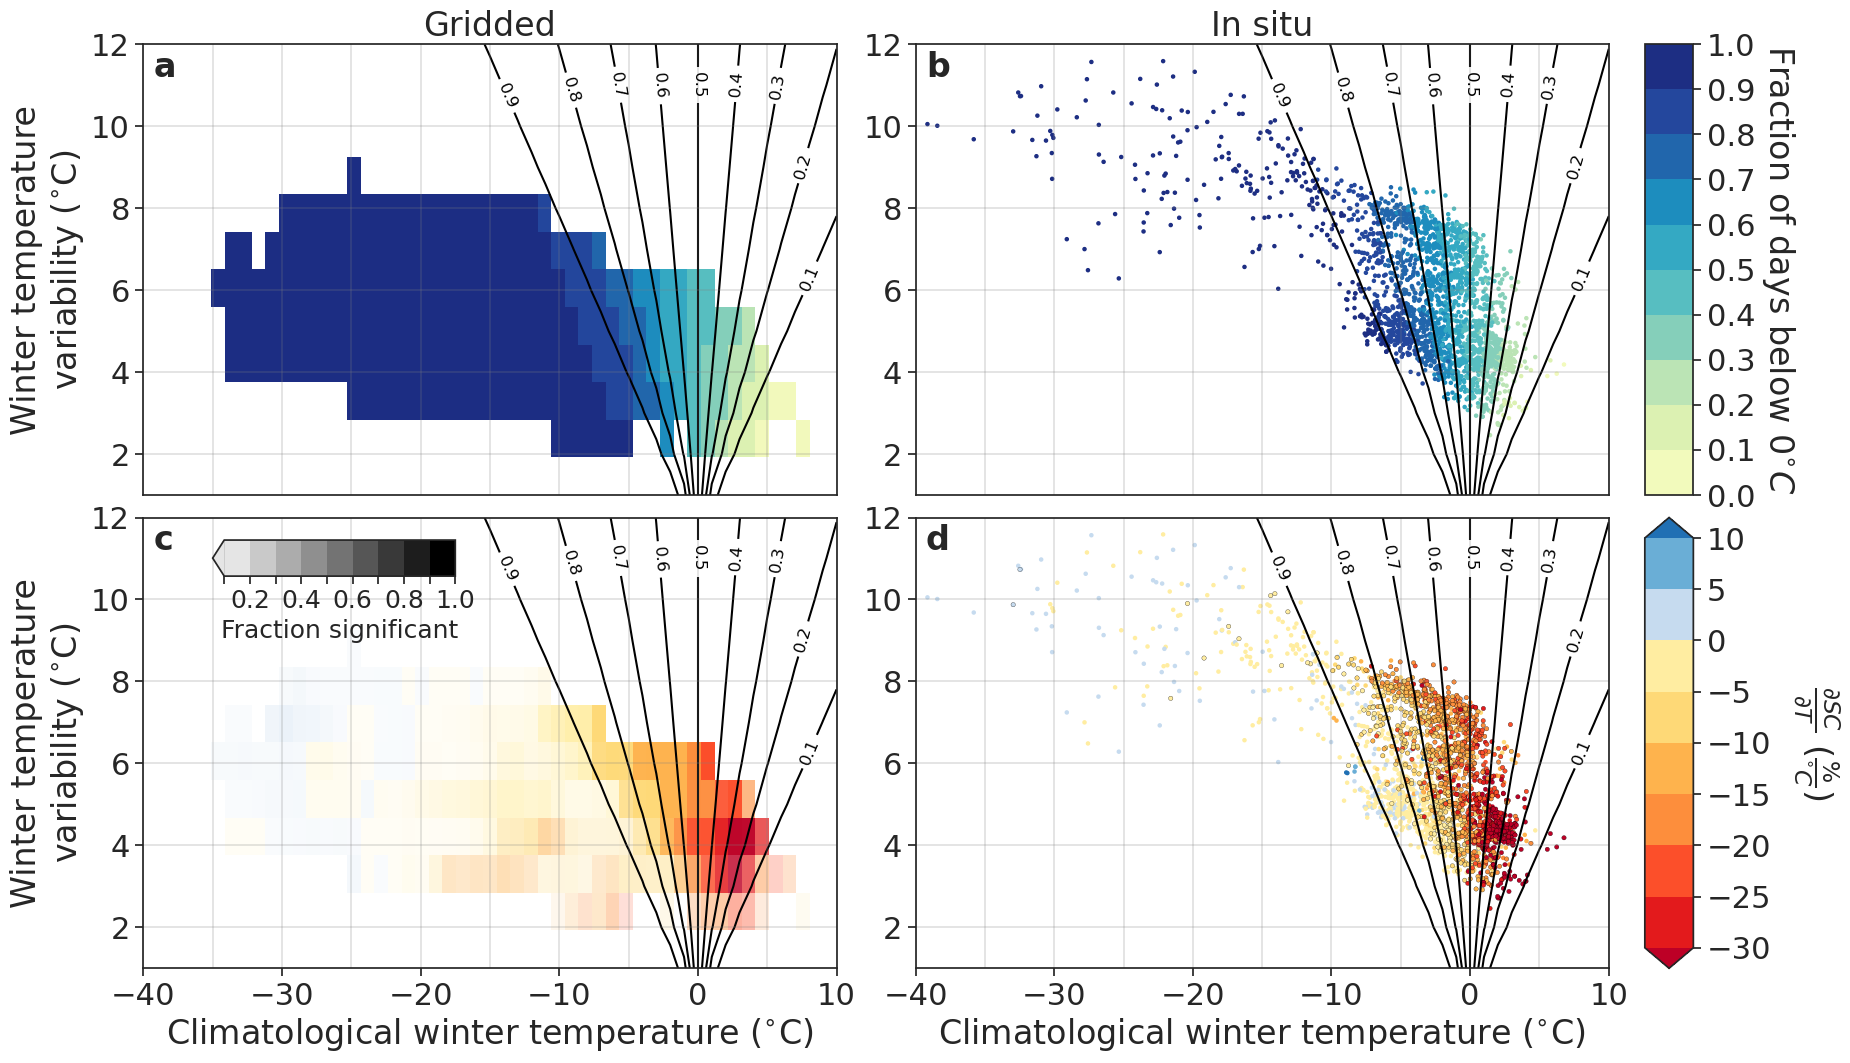

In [11]:
fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(nrows=2,ncols=4,height_ratios=[4,4,],width_ratios=[10,0.1,10,0.7],hspace=0.05,wspace=0.1,figure=fig)

ax2 = plt.subplot(gs[0,0])
cmap = mpl.colors.ListedColormap(sns.color_palette("YlGnBu",10))
norm = plt.Normalize(vmin=0,vmax=1)
ax2.imshow(cold_frac_avg[::-1],cmap=cmap,norm=norm,extent=[-40,10,1,12],aspect='auto')
cs = ax2.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
ax2.clabel(cs,cs.levels,manual=[(-12,11),(-8,11),(-6,11),(-2,11),(-1,11),(4,11),(5.5,11),(8,9),(10,6)][::-1],fontsize=12)
ax2.set_xlabel("")
ax2.set_ylabel("Winter temperature\nvariability ($^{\circ}$C)")
ax2.set_xlim(-40,10)
ax2.set_xticks([])
ax2.title.set_text("Gridded")


ax4 = plt.subplot(gs[0,2])
insitu_df.plot.scatter(x='tavg',y='tavg_std',c='cold_frac',s=5,cmap=cmap,norm=norm,colorbar=False,ax=ax4)
cs = ax4.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
ax4.clabel(cs,cs.levels,manual=[(-12,11),(-8,11),(-6,11),(-2,11),(-1,11),(4,11),(5.5,11),(8,9),(10,6)][::-1],fontsize=12)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_xlim(-40,10)
ax4.set_xticks([])
ax4.title.set_text("In situ")

cax1 = plt.subplot(gs[0,3])
sm = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax1,orientation='vertical',drawedges=False,ticks=np.linspace(0,1,11),pad=0.03,shrink=0.9)
cbar.ax.set_ylabel('Fraction of days below $0^{\circ}C$',rotation=-90,labelpad=30)

dsc_cols = np.concatenate([sns.color_palette("YlOrRd_r",7),sns.color_palette("Blues",3)])
dsc_cmap = mpl.colors.ListedColormap(dsc_cols[1:-1])
dsc_cmap.set_under(dsc_cols[0])
dsc_cmap.set_over(dsc_cols[-1])
dsc_norm = plt.Normalize(vmin=-30,vmax=10)
ax5 = plt.subplot(gs[1,0])
ax5.imshow(dsc_dt_avg[::-1],cmap=dsc_cmap,norm=dsc_norm,alpha=(sig_avg_scale[::-1]).fillna(0),extent=[-40,10,1,12],aspect='auto')
cs = ax5.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
ax5.clabel(cs,cs.levels,manual=[(-12,11),(-8,11),(-6,11),(-2,11),(-1,11),(4,11),(5.5,11),(8,9),(10,6)][::-1],fontsize=12)
ax5.set_xlabel("Climatological winter temperature ($^{\circ}$C)")
ax5.set_ylabel("Winter temperature\nvariability ($^{\circ}$C)")
ax5.set_xlim(-40,10)
ax5_cax = ax5.inset_axes([0.1,0.87,0.35,0.08])
colors = [(0,0,0,a) for a in np.linspace(0.1,1,10)]  # R, G, B, Alpha - from transparent red to opaque red
cmap_name = 'alpha_test'
alpha_cmap = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=9)
alpha_cmap.set_under(colors[0])
alpha_norm = plt.Normalize(vmin=0.1,vmax=1)
alpha_sm = plt.cm.ScalarMappable(norm=alpha_norm,cmap=alpha_cmap)
alpha_sm.set_array([])
alpha_cbar = fig.colorbar(alpha_sm,cax=ax5_cax,orientation='horizontal',ticks=np.linspace(0.1,1,10),drawedges=False,extend='min',pad=0,shrink=0.9)
alpha_cbar.ax.set_xlabel('Fraction significant',fontsize=18)
alpha_cbar.ax.tick_params(labelsize=18)

for l in alpha_cbar.ax.get_xticklabels()[::2]:
    l.set_visible(False)
ax6 = plt.subplot(gs[1,2])
insitu_df[insitu_df['dsc_dt_p']>=0.01].plot.scatter(x='tavg',y='tavg_std',c='dsc_dt',s=5,cmap=dsc_cmap,norm=dsc_norm,colorbar=False,ax=ax6)
insitu_df[insitu_df['dsc_dt_p']<0.01].plot.scatter(x='tavg',y='tavg_std',c='dsc_dt',s=10,edgecolor='black',lw=0.2,cmap=dsc_cmap,norm=dsc_norm,colorbar=False,ax=ax6)
cs = ax6.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
ax6.clabel(cs,cs.levels,manual=[(-12,11),(-8,11),(-6,11),(-2,11),(-1,11),(4,11),(5.5,11),(8,9),(10,6)][::-1],fontsize=12)
ax6.set_xlabel("Climatological winter temperature ($^{\circ}$C)")
ax6.set_ylabel("")
ax6.set_xlim(-40,10)

cax2 = plt.subplot(gs[1,3])
sm = plt.cm.ScalarMappable(norm=dsc_norm,cmap=dsc_cmap)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax2,orientation='vertical',drawedges=False,ticks=np.arange(-30,11,5),extend='both',pad=0,shrink=0.9)
cbar.ax.set_ylabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)',rotation=-90,labelpad=50)
labels = ['a','b','c','d']
i=0
for ax in [ax2,ax4,ax5,ax6]:
    ax.vlines(np.arange(-40,11,5),ymin=1,ymax=12,color='grey',lw=0.3)
    ax.hlines(np.arange(2,12,2),xmin=-40,xmax=10,color='grey',lw=0.3)

    ax.text(0.015,0.985,labels[i],ha='left',va='top',fontweight='bold',fontsize=24,transform=ax.transAxes)
    i+=1

plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','png','cold_frac.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','pdf','cold_frac.pdf'),bbox_inches='tight',dpi=350)

plt.show()


In [42]:
insitu_df['cold_frac_gauss'] = insitu_df.apply(lambda row: NormalDist(row['tavg'],row['tavg_std']).cdf(0),axis=1)

In [182]:
from scipy.stats import pearsonr
r = pearsonr(insitu_df['cold_frac_gauss'],insitu_df['cold_frac'])
rmse = np.sqrt(np.power(insitu_df['cold_frac_gauss']-insitu_df['cold_frac'],2).sum()/len(insitu_df))

np.float64(0.025529420970466513)

/scratch/ipykernel_1706198/2932036276.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(0,101,20))
/scratch/ipykernel_1706198/2932036276.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(0,101,20))


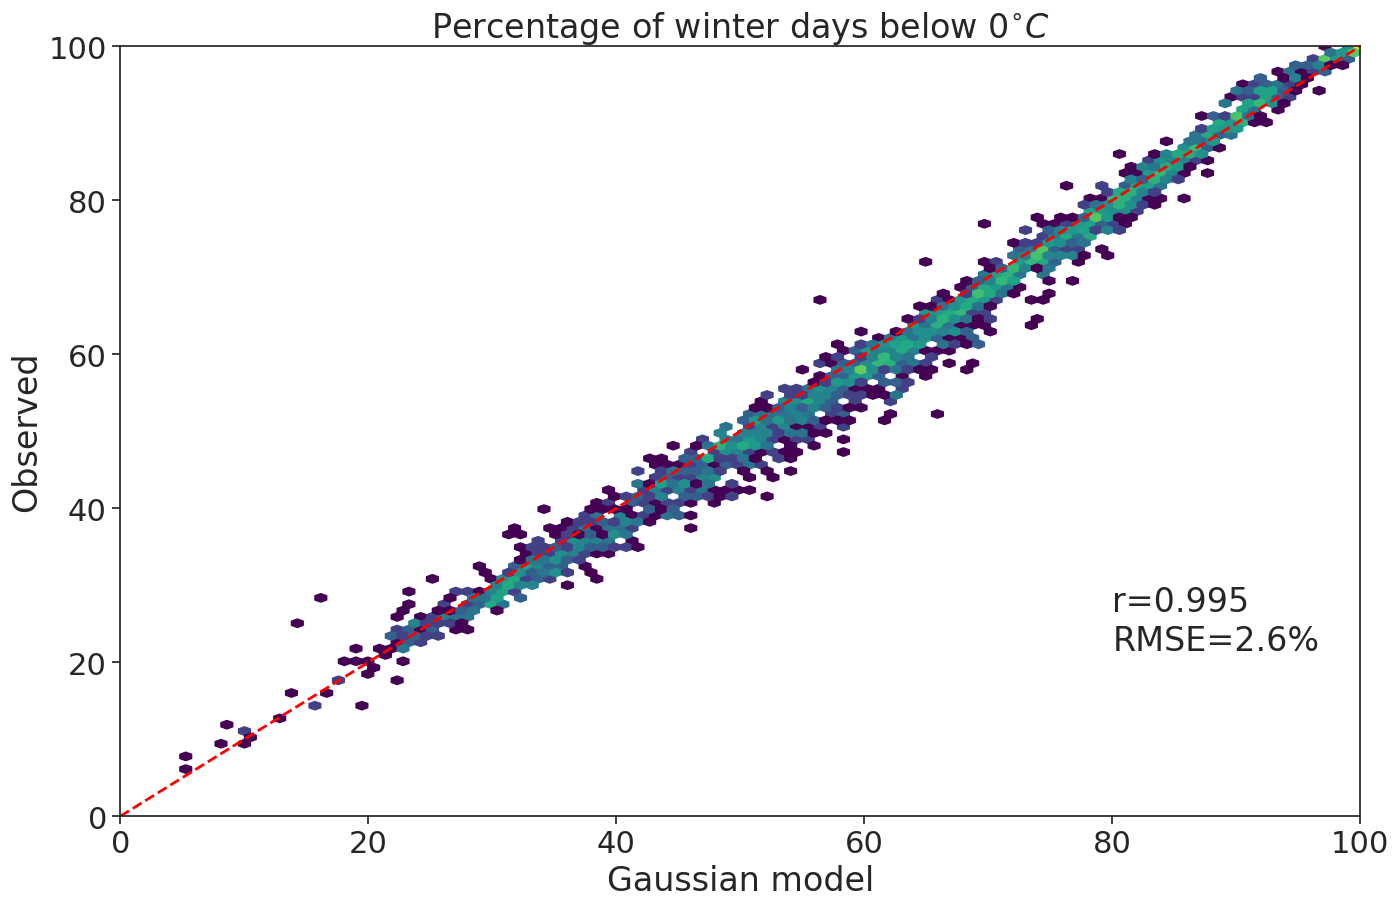

In [187]:
fig,ax=plt.subplots(figsize=(16,10))
ax.hexbin(insitu_df['cold_frac_gauss'],insitu_df['cold_frac'],bins='log',cmap='viridis')
# insitu_df.plot.scatter(x='cold_frac_gauss',y='cold_frac',ax=ax)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot([0,1],[0,1],color='red',lw=2,linestyle='--')
ax.set_xlabel("Gaussian model")
ax.set_ylabel("Observed")
ax.title.set_text("Percentage of winter days below $0^{\circ}C$")
ax.text(0.8,0.3,f'r={np.round(r[0],3)}',ha='left',va='top')
ax.text(0.8,0.25,f'RMSE={100*np.round(rmse,3)}%',ha='left',va='top')
ax.set_xticklabels(np.arange(0,101,20))
ax.set_yticklabels(np.arange(0,101,20))

plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','png','gauss_eval.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','pdf','gauss_eval.pdf'),bbox_inches='tight',dpi=350)
